**Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

**Read Datasets**

In [2]:
train_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv", low_memory=False)
test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv", low_memory=False)
sample_submission = pd.read_csv("/kaggle/input/System-Threat-Forecaster/sample_submission.csv")

In [3]:
# Create a copy for EDA
explore_df = train_df.copy()

**Dataset Overview**

In [4]:
print("Dataset Shape:", explore_df.shape)  # Number of rows and columns
print("\nFirst Few Rows:\n", explore_df.head())  # Preview of data
print("\nDataset Info:")
explore_df.info()  # Data types and non-null counts


Dataset Shape: (100000, 76)

First Few Rows:
                           MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0          

**Target Variable Distribution**


Target Value Counts:
 target
1    50525
0    49475
Name: count, dtype: int64


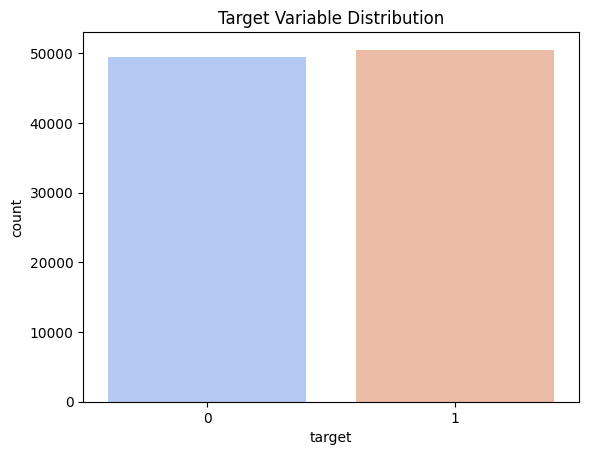

In [5]:
print("\nTarget Value Counts:\n", explore_df['target'].value_counts())

sns.countplot(x='target', data=explore_df, palette="coolwarm")
plt.title("Target Variable Distribution")
plt.show()


**Summary Statistics**

In [6]:
print("\nSummary Statistics:\n", explore_df.describe())  # Only numerical features



Summary Statistics:
        IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%        

**Missing Values Analysis**


Missing Values Count:
 MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64

Missing Values Percentage:
 MachineID           0.00
ProductName         0.00
EngineVersion       0.00
AppVersion          0.00
SignatureVersion    0.00
                    ... 
IsGamer             0.56
RegionIdentifier    0.56
DateAS              0.00
DateOS              0.02
target              0.00
Length: 76, dtype: float64


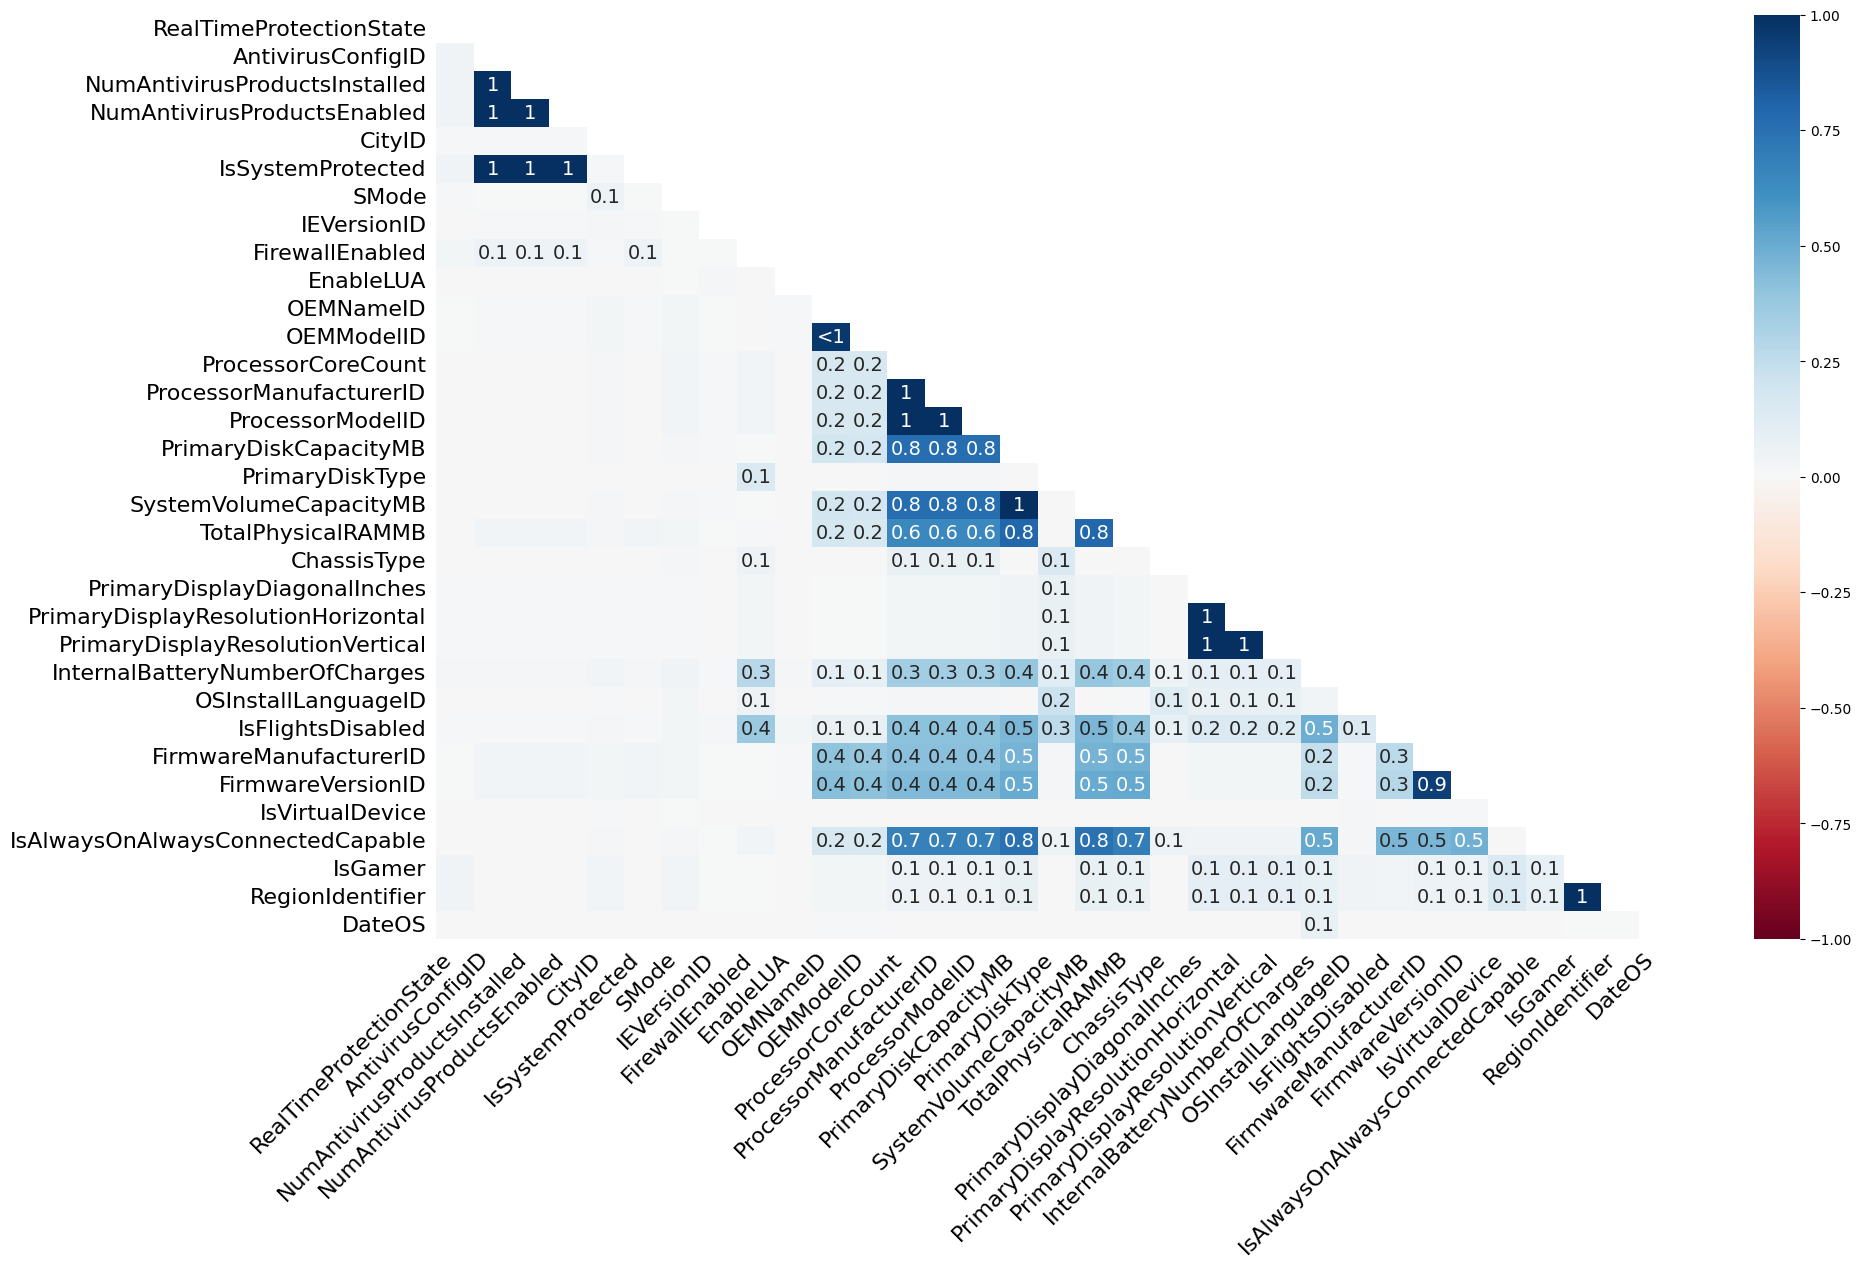

In [7]:
print("\nMissing Values Count:\n", explore_df.isna().sum())
print("\nMissing Values Percentage:\n", (explore_df.isna().sum() * 100 / len(explore_df)).round(2))

# Visualize missing data
msno.heatmap(explore_df)
plt.show()


**Categorical and Numerical Feature Analysis**

In [8]:
# Select categorical and numerical features
categorical_df = explore_df.select_dtypes(include=['object'])
numerical_df = explore_df.select_dtypes(include=['int64', 'float64'])

# Print the samples and the counts
print("\nNumber of Categorical Features:", categorical_df.shape[1])  # Number of columns in categorical_df
print("\nCategorical Features Sample:\n", categorical_df.head())

print("\nNumber of Numerical Features:", numerical_df.shape[1])  # Number of columns in numerical_df
print("\nNumerical Features Sample:\n", numerical_df.head())




Number of Categorical Features: 28

Categorical Features Sample:
                           MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion PlatformType Processor OSVersion  \
0   4.18.1807.18075     1.275.1003.0    windows10       x86  10.0.0.0   
1   4.18.1807.18075     1.273.1465.0    windows10       x64  10.0.0.0   
2   4.18.1807.18075     1.275.1546.0    windows10       x64  10.0.0.0   
3  4.12.17007.18011     1.275.1141.0    windows10       x64  10.0.0.0   
4    4.13.17134.228     1.275.1283.0    windows10       x86  10.0.0.0   

  OsPlatformSubRelease                                   OSBuildLab  ...  \
0              

**Numerical Feature Distribution**

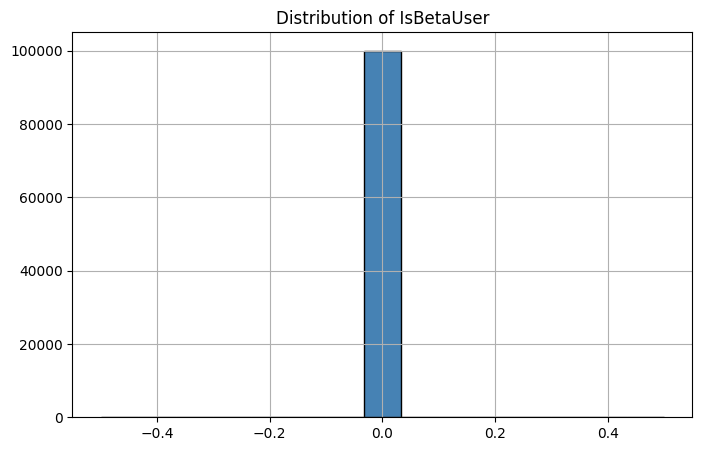

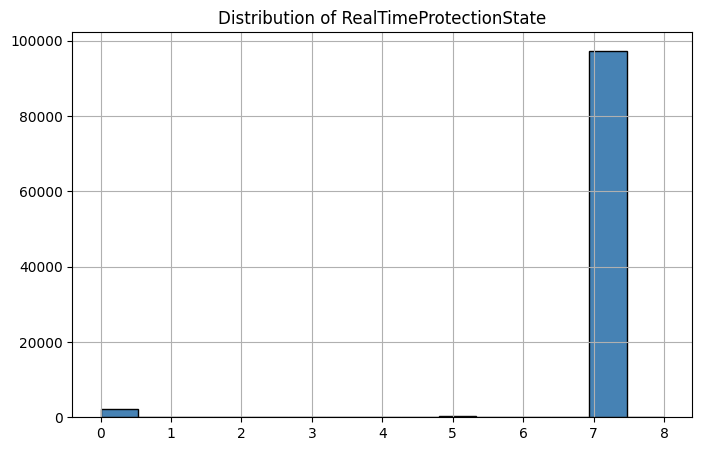

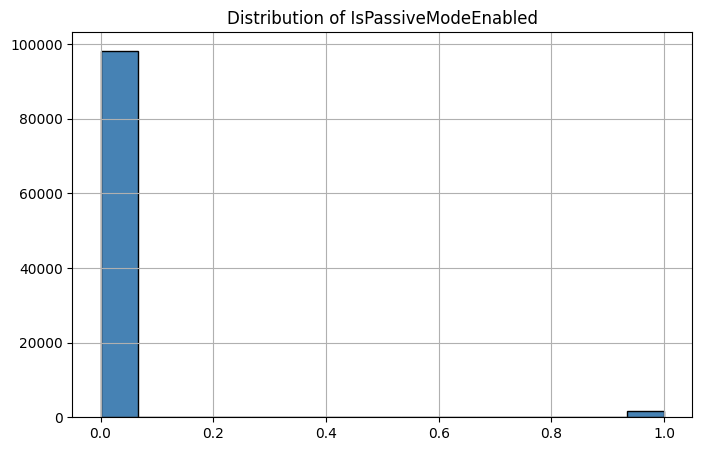

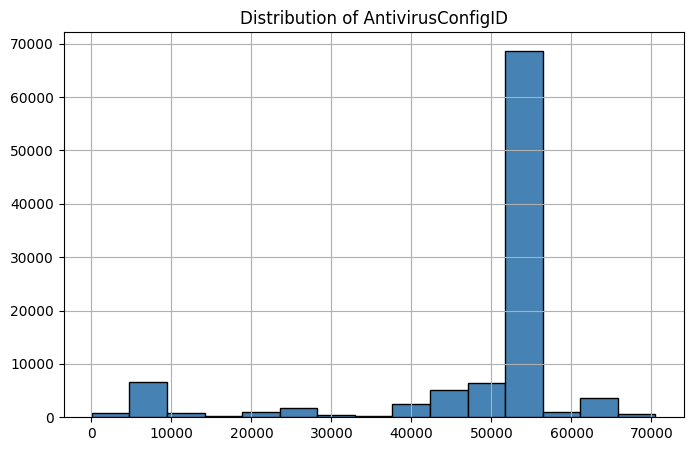

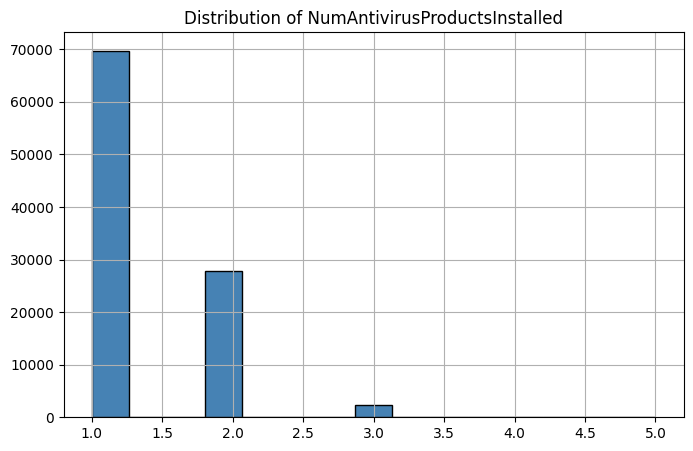

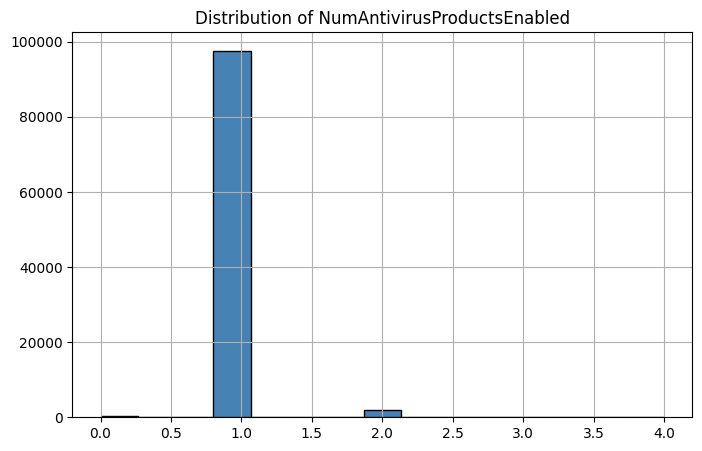

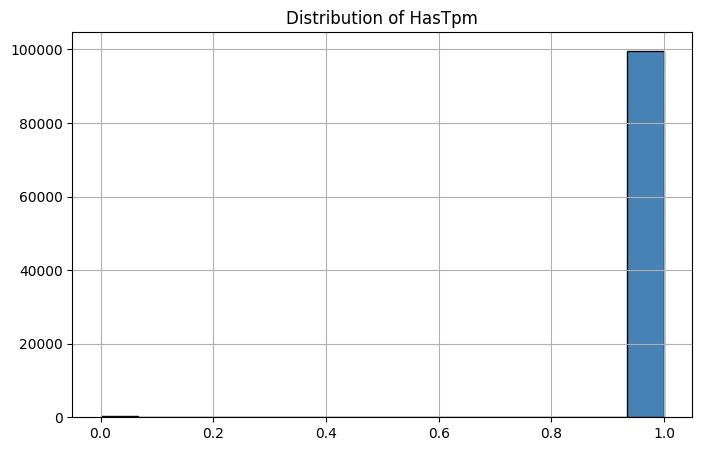

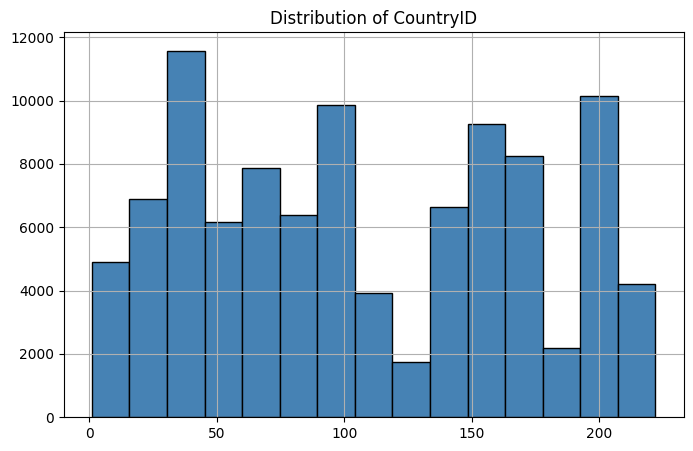

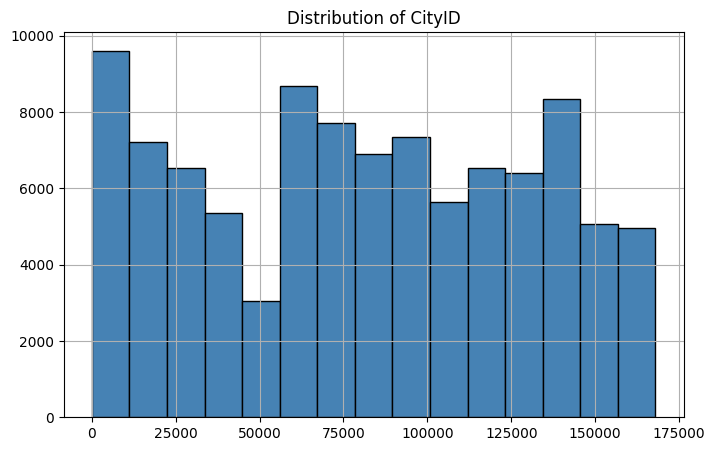

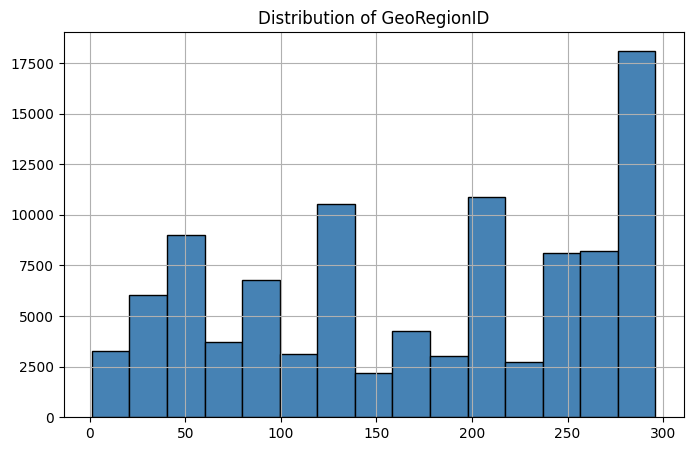

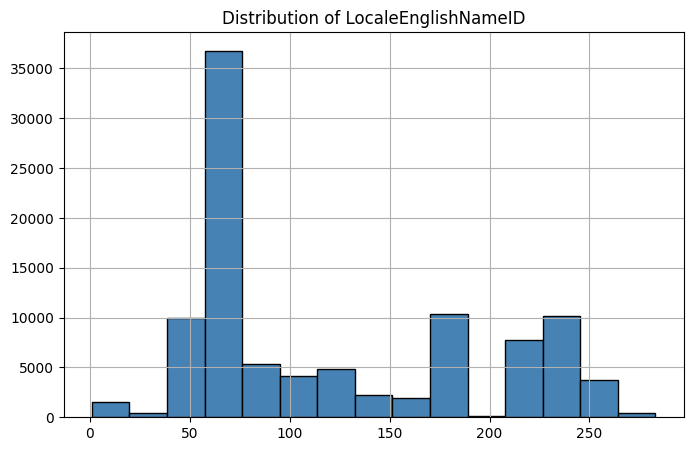

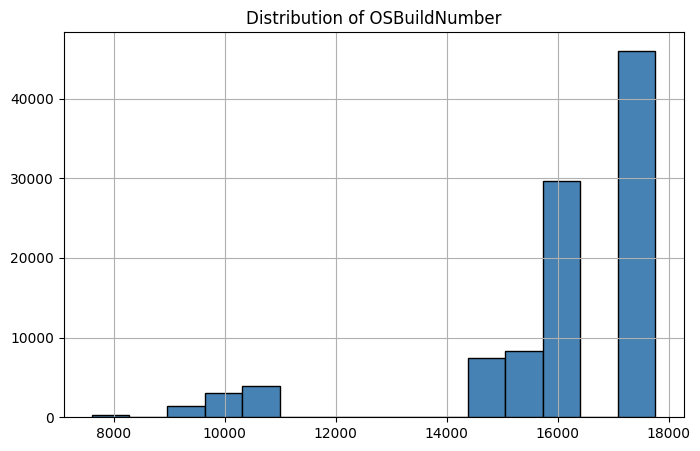

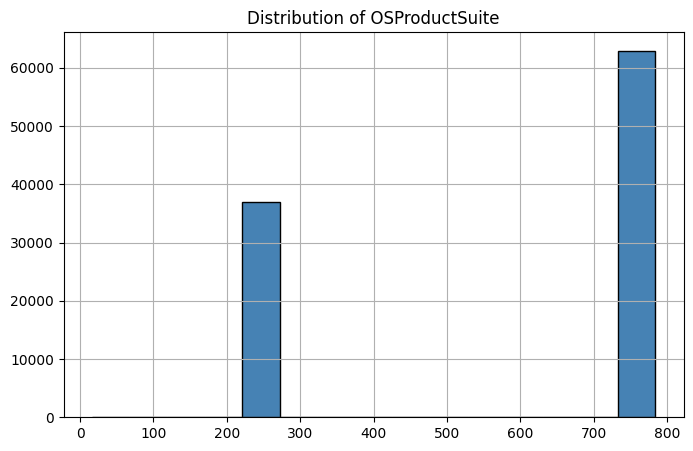

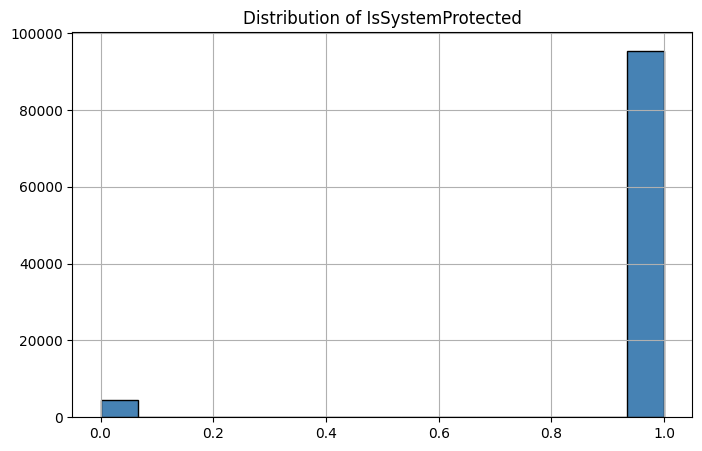

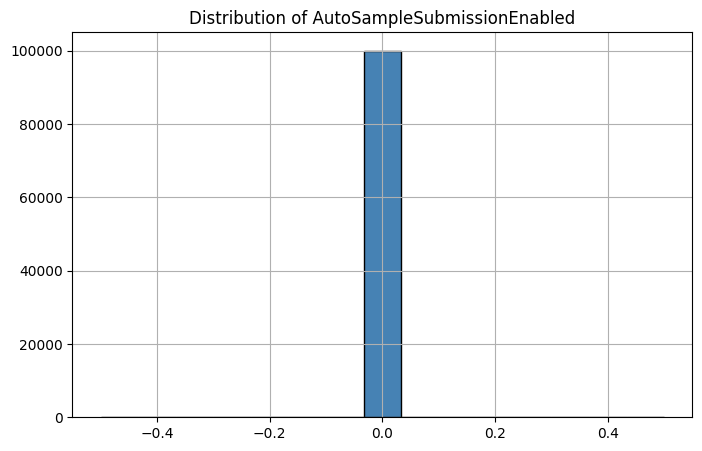

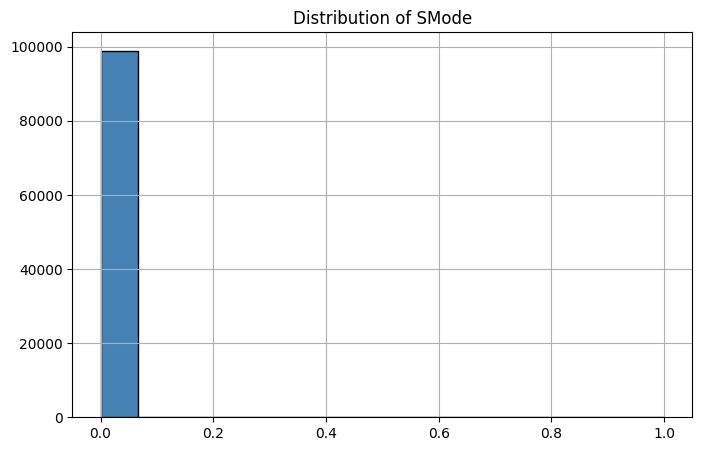

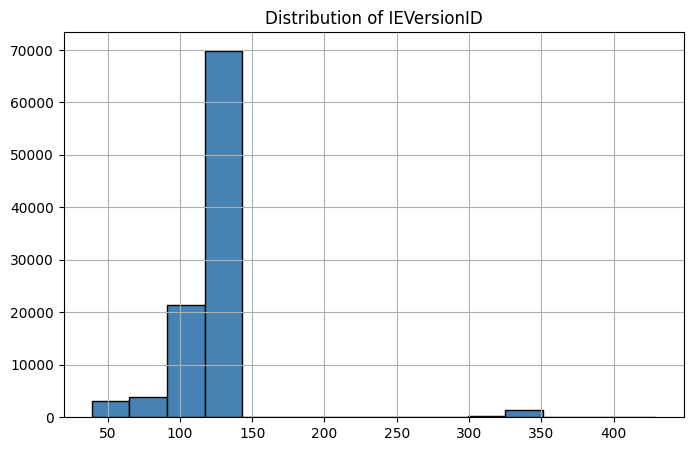

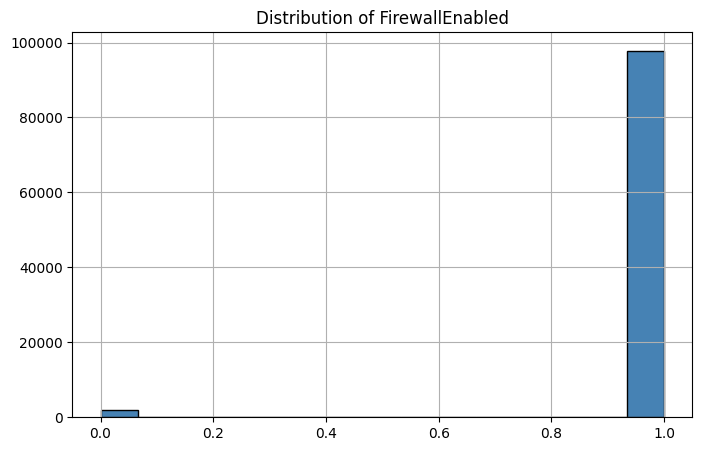

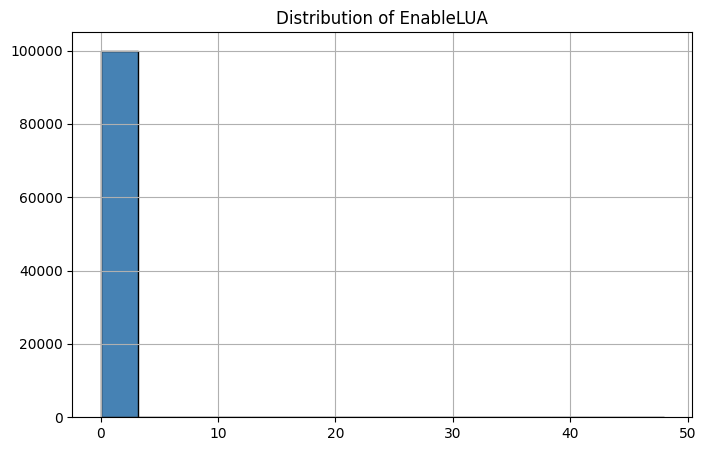

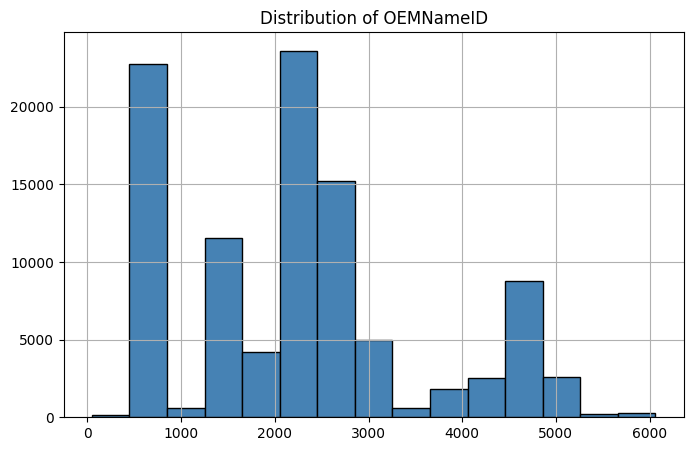

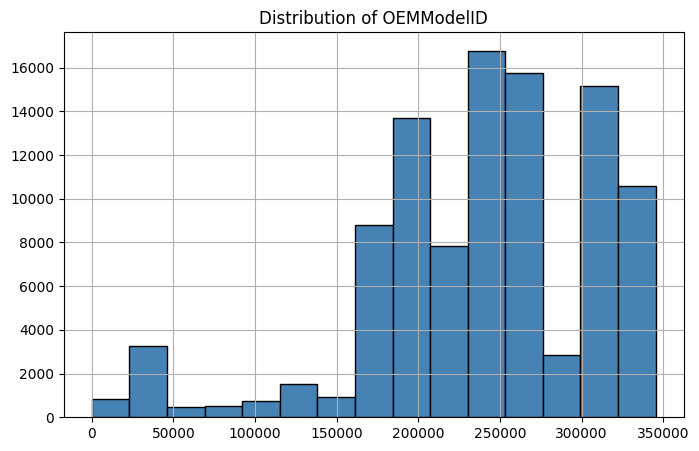

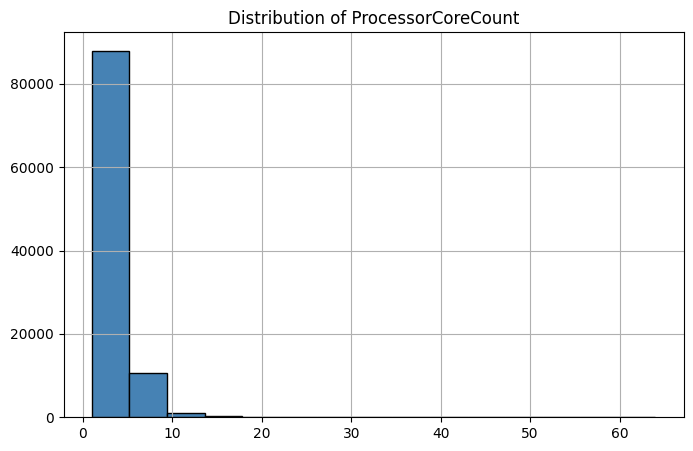

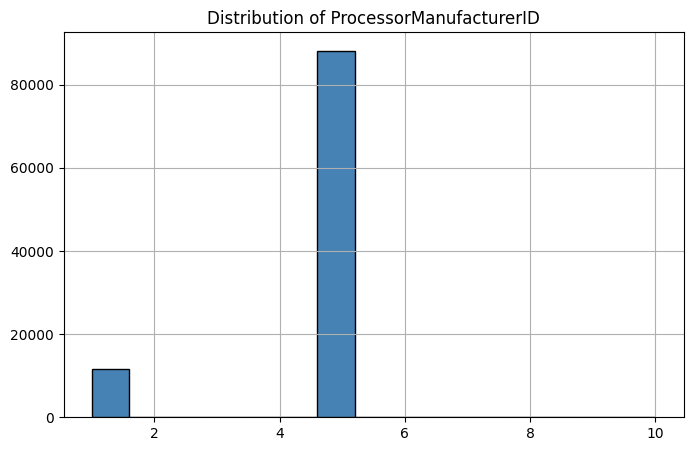

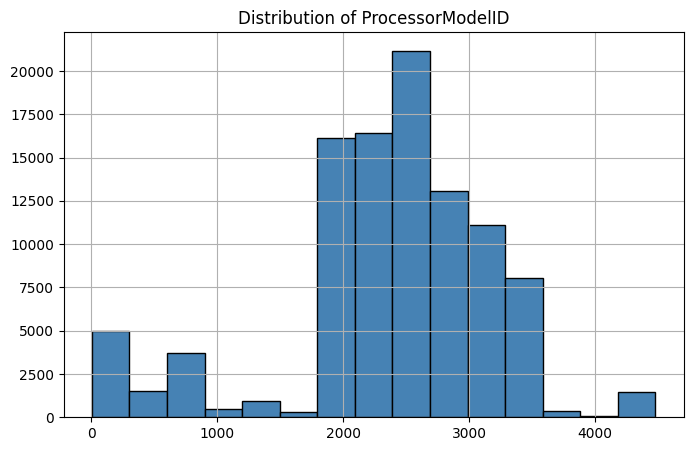

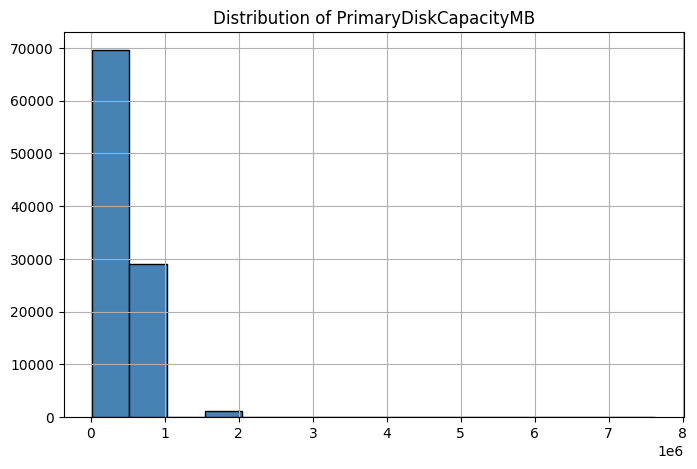

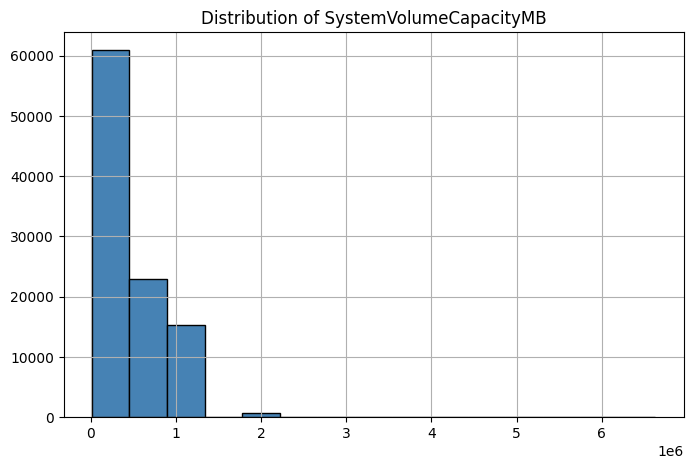

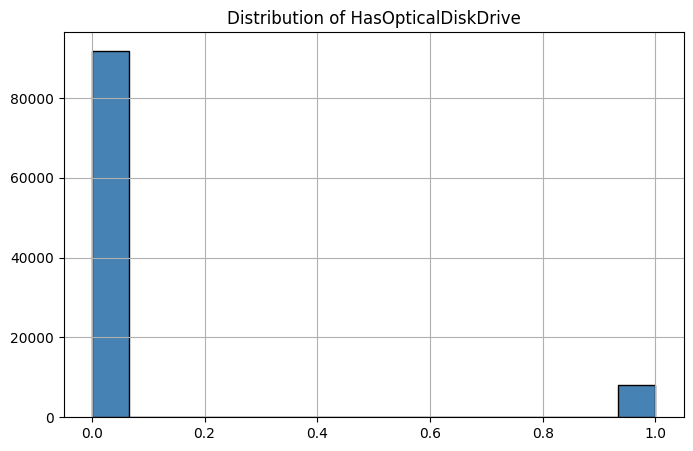

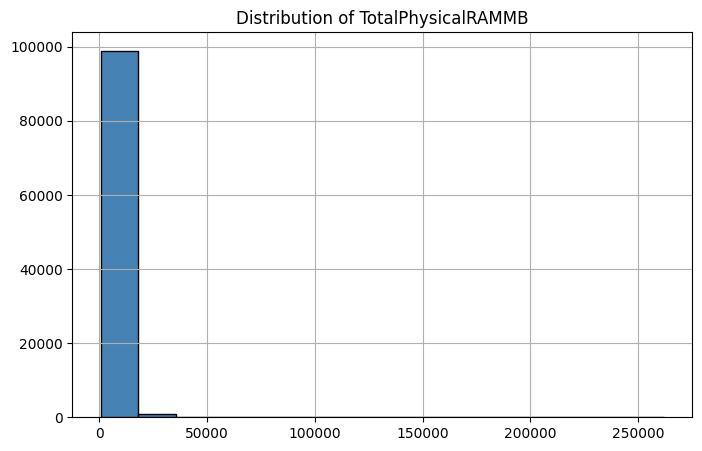

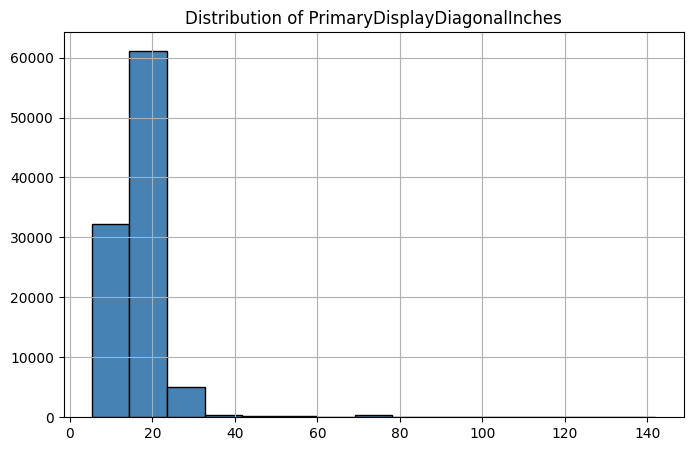

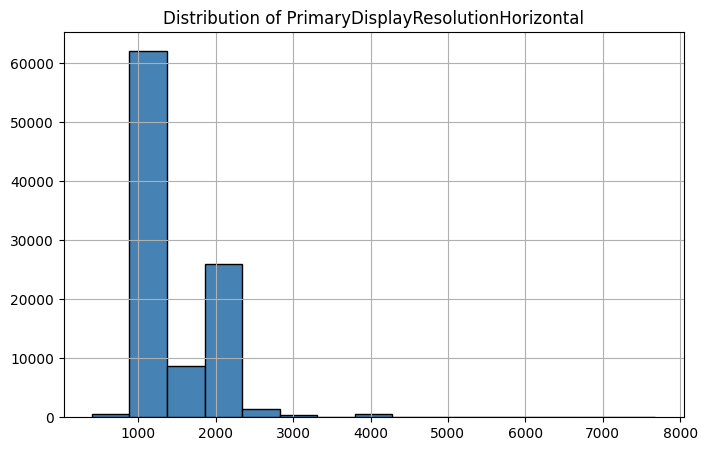

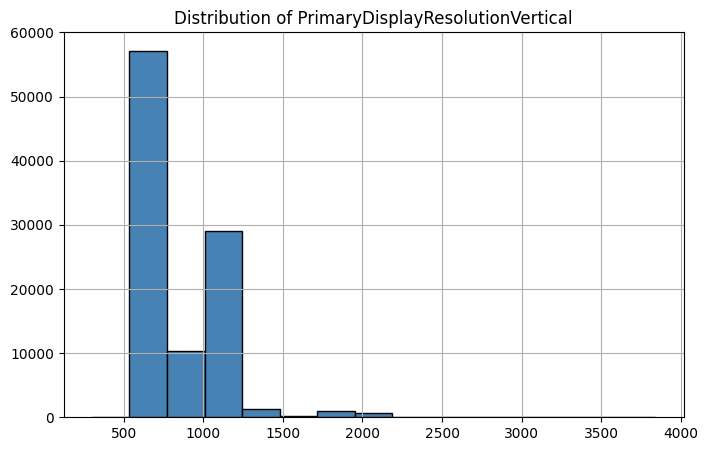

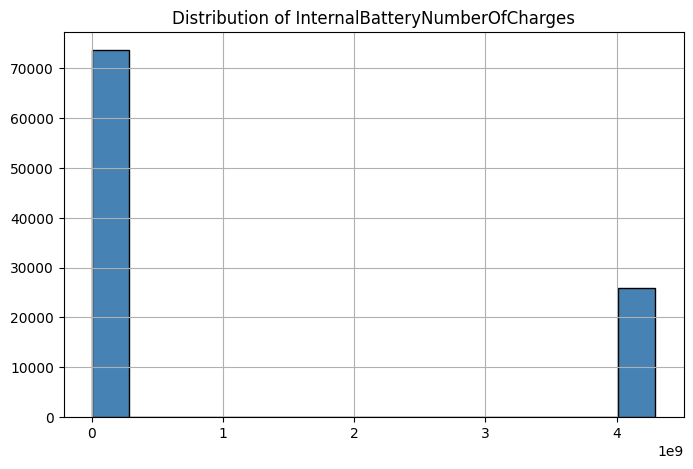

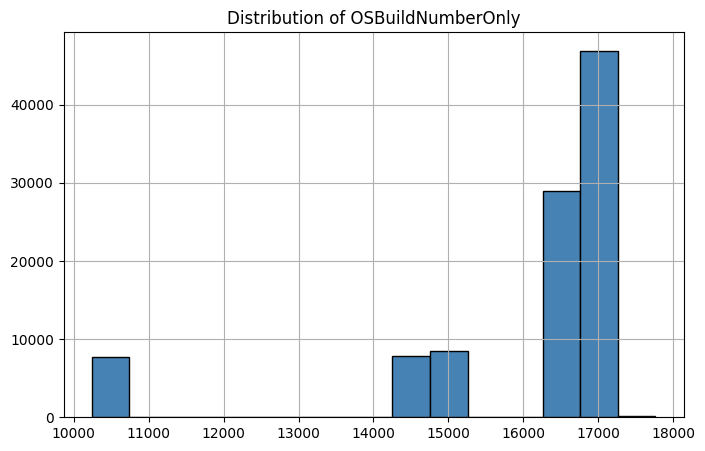

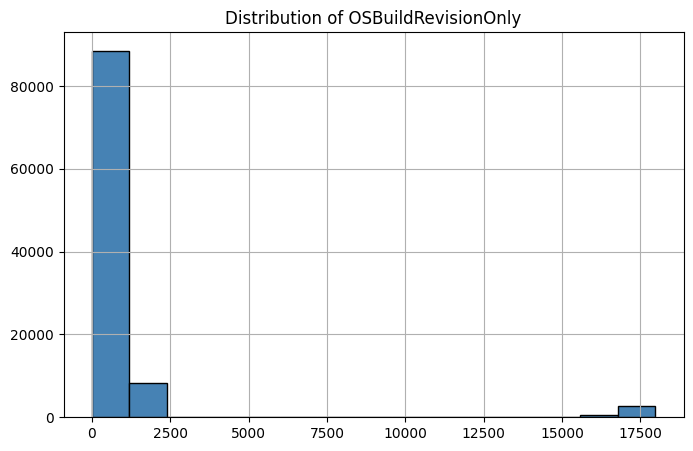

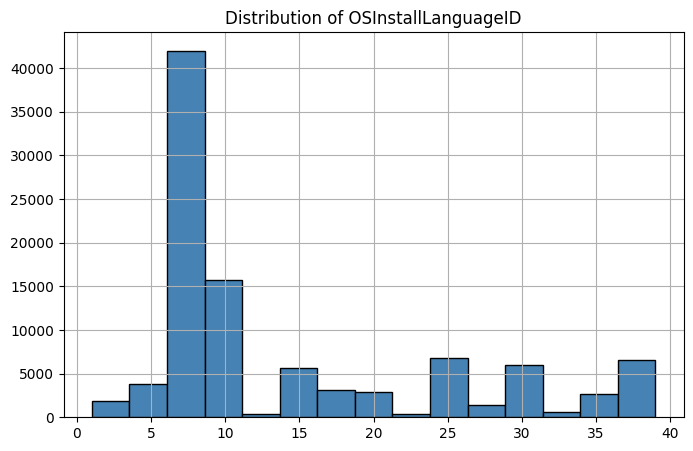

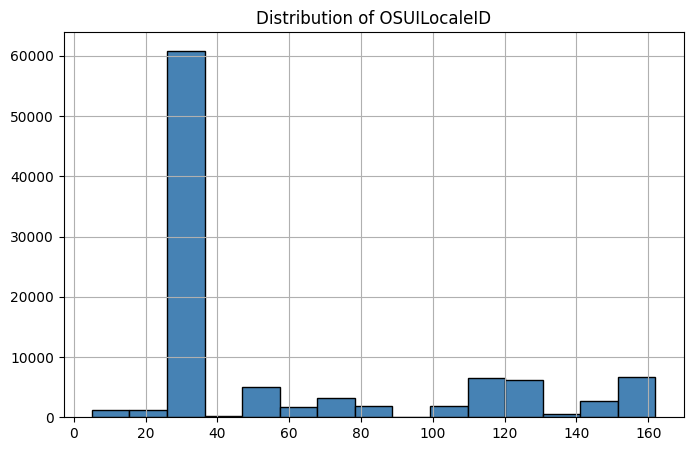

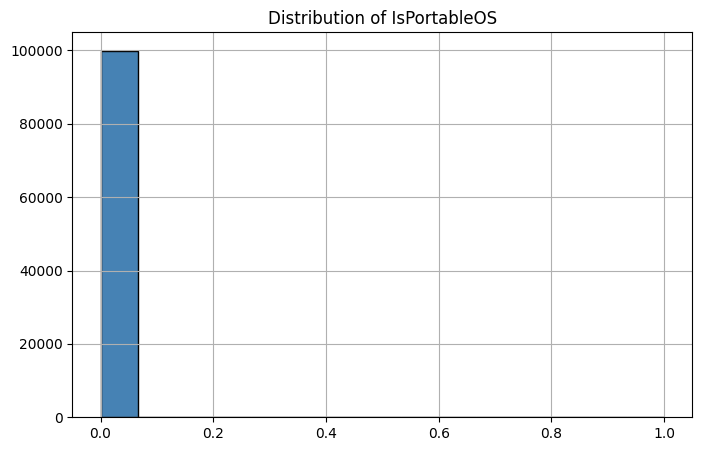

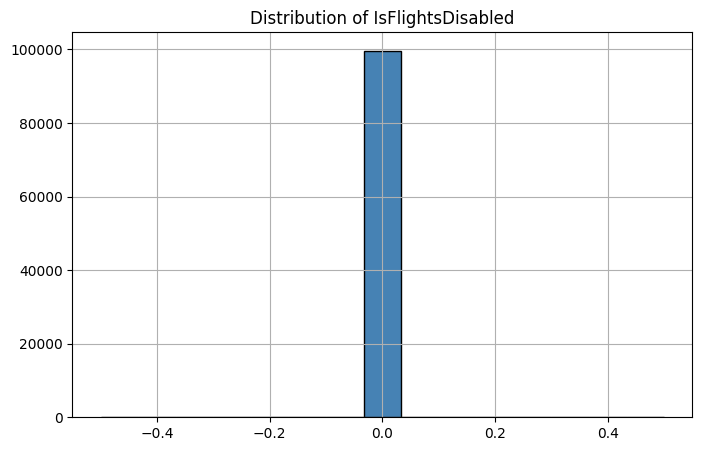

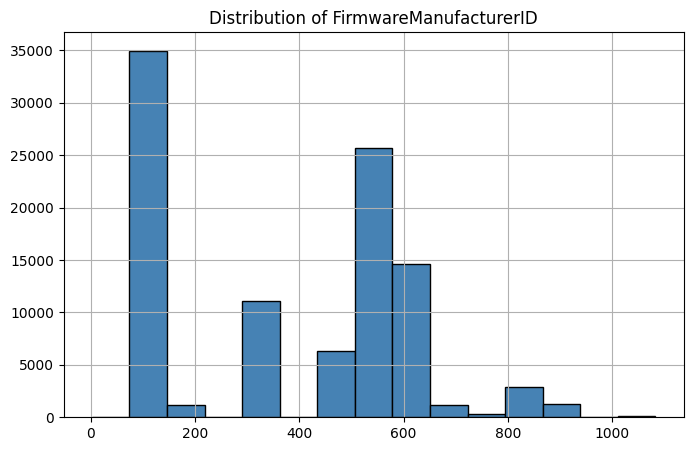

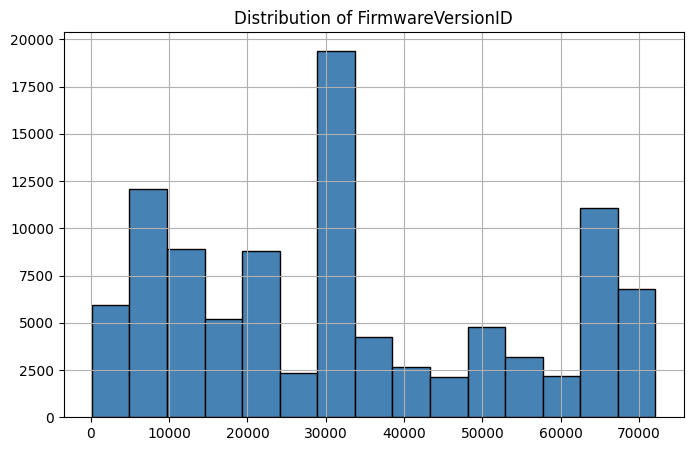

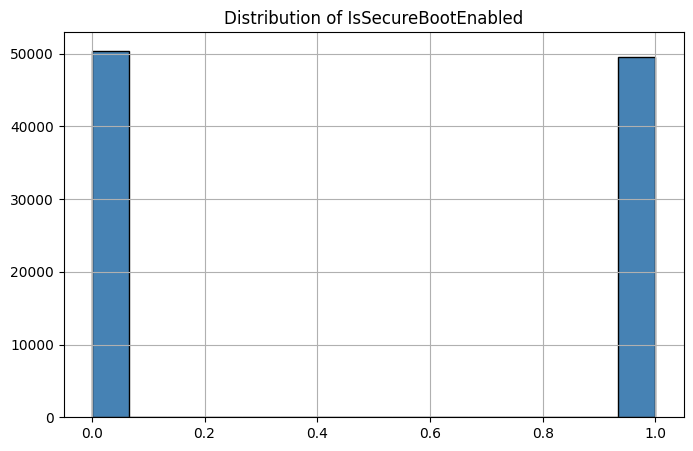

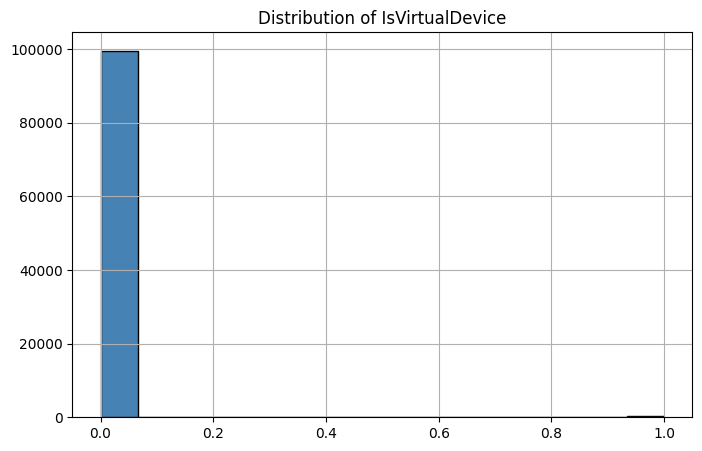

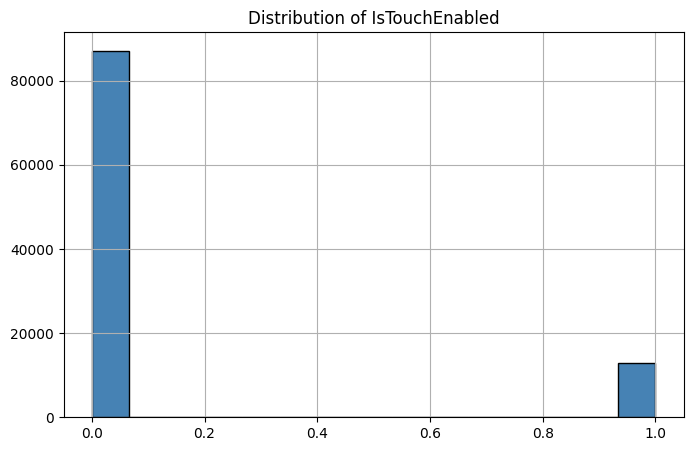

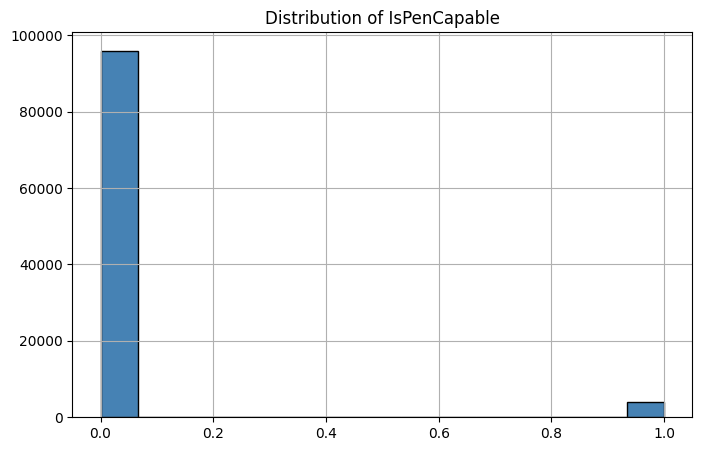

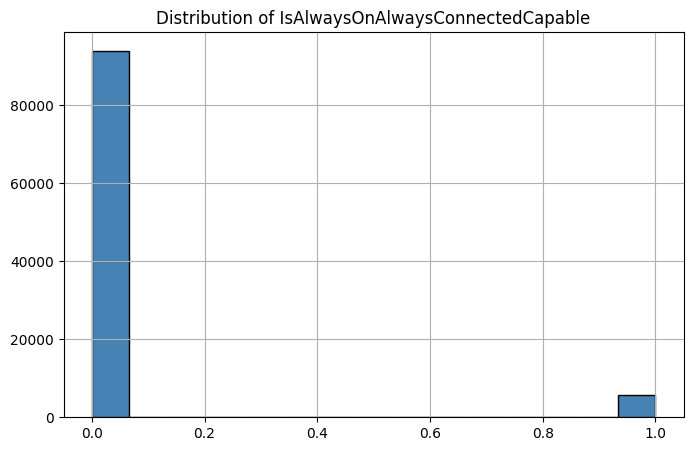

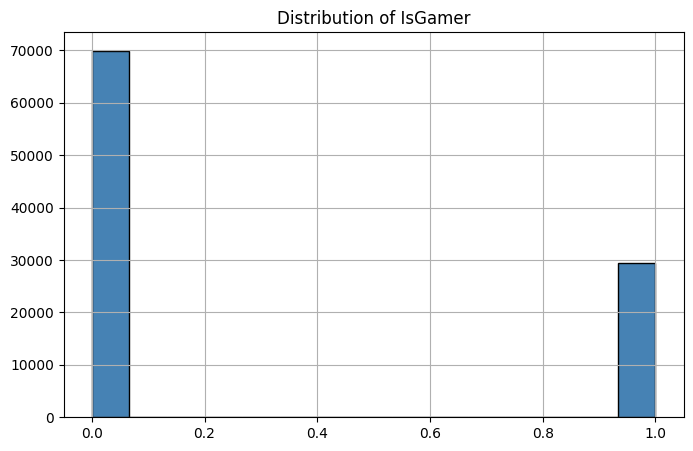

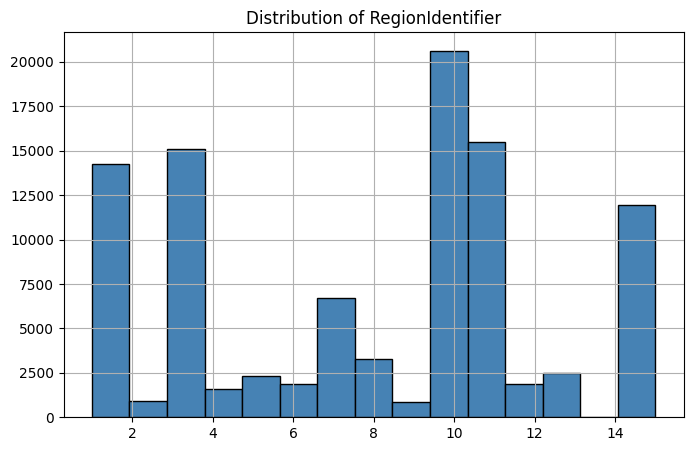

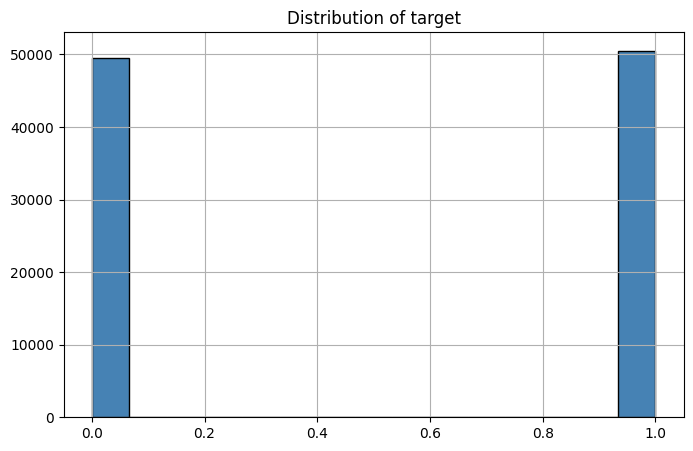

In [9]:
'''numerical_df.hist(bins=15, figsize=(14, 7), color='steelblue', edgecolor='black')
plt.suptitle("Numerical Feature Distributions")
plt.show() '''

for column in numerical_df.columns:
    numerical_df[column].hist(bins=15, figsize=(8, 5), color='steelblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.show()


**Outlier Detection Using Boxplots**

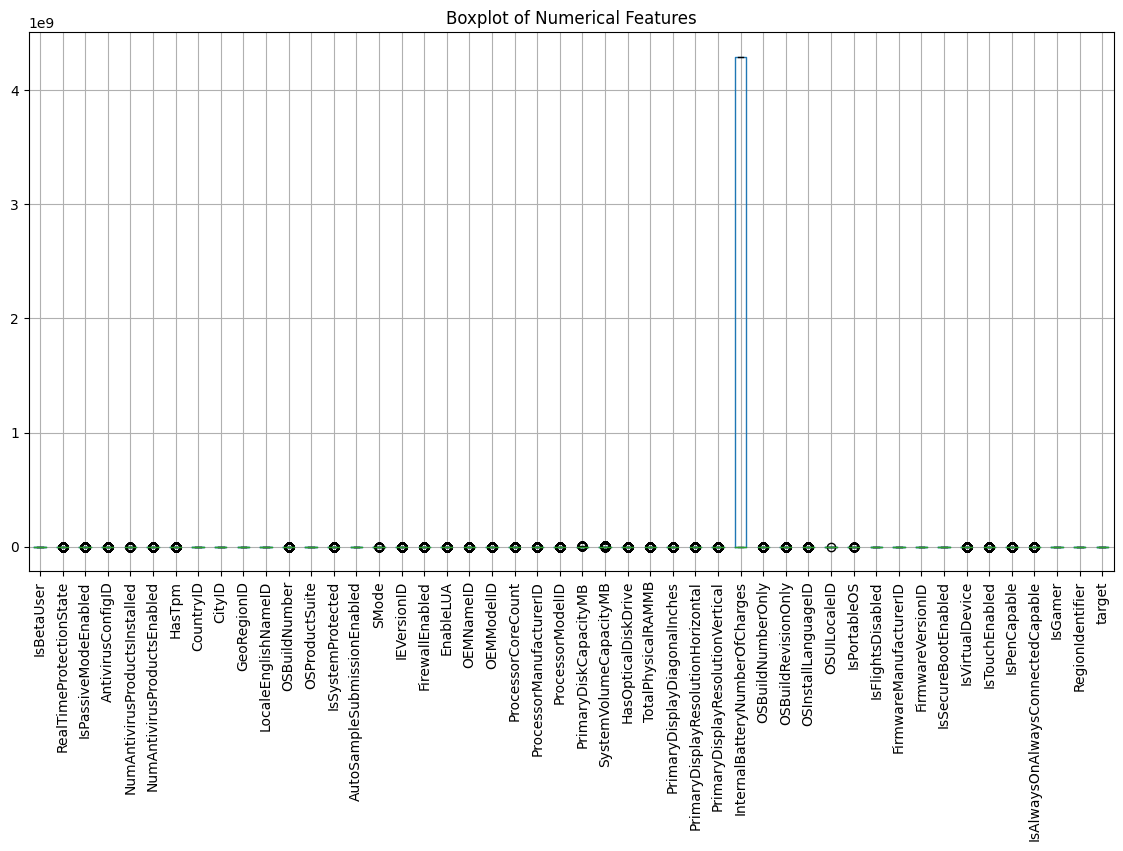

In [10]:
plt.figure(figsize=(14, 7))
explore_df[numerical_df.columns].boxplot(rot=90)
plt.title("Boxplot of Numerical Features")
plt.show()


**Correlation Analysis**

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


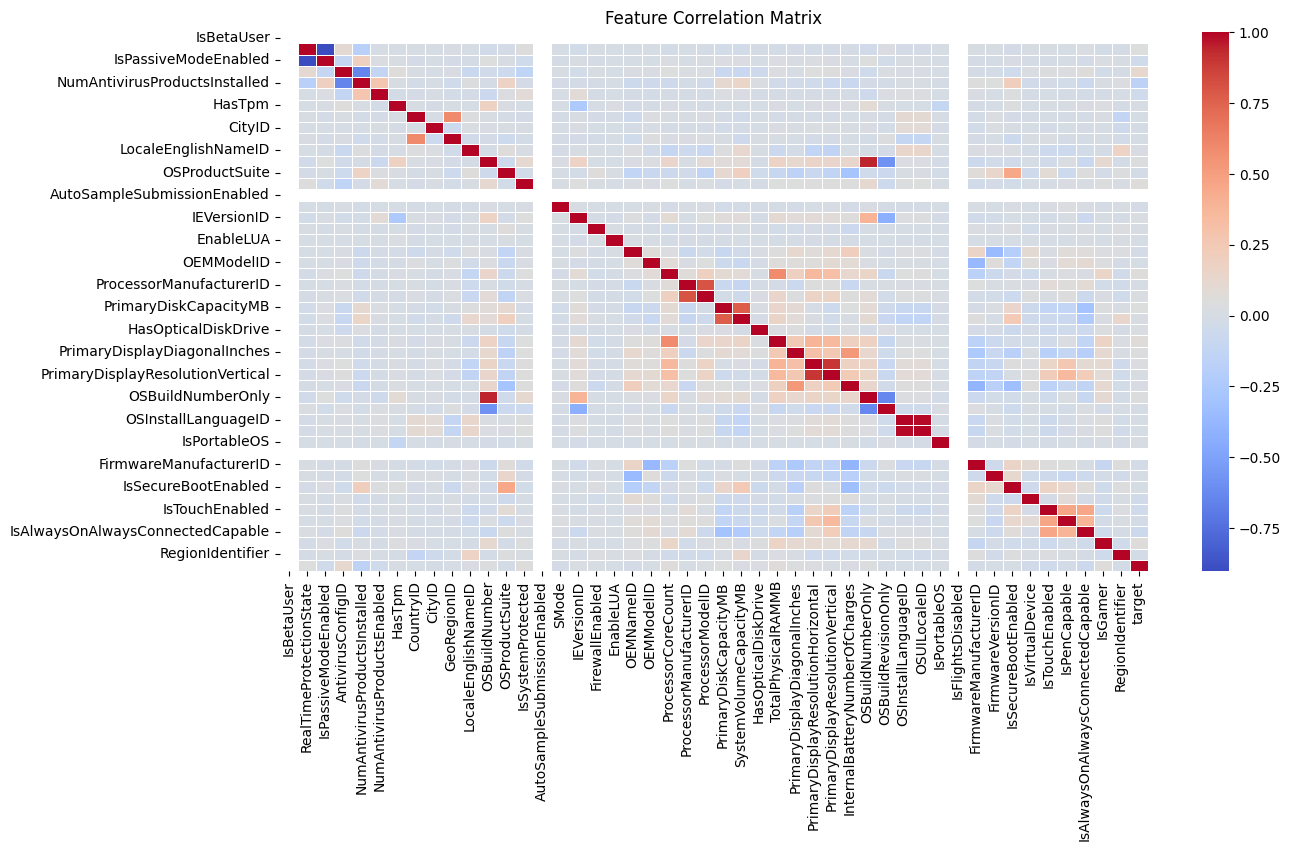

In [11]:
corr = numerical_df.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


**Scatter Matrix**

In [12]:
'''
scatter_matrix(numerical_df, figsize=(14, 7), diagonal="hist")
plt.suptitle("Scatter Matrix of Numerical Features")
plt.show()
'''

'\nscatter_matrix(numerical_df, figsize=(14, 7), diagonal="hist")\nplt.suptitle("Scatter Matrix of Numerical Features")\nplt.show()\n'

**Unique Values in Each Column**

In [13]:
print("\nUnique Values Per Column:\n", explore_df.nunique())



Unique Values Per Column:
 MachineID           99835
ProductName             2
EngineVersion          37
AppVersion             69
SignatureVersion     2735
                    ...  
IsGamer                 2
RegionIdentifier       15
DateAS               2695
DateOS                112
target                  2
Length: 76, dtype: int64


**Duplicate Values**

In [14]:
print("\nDuplicate Rows Count:", explore_df.duplicated().sum())



Duplicate Rows Count: 165


In [15]:
# Convert Date columns into datetime format
date_cols = ["DateOS", "DateAS"]
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], errors="coerce")
    test_df[col] = pd.to_datetime(test_df[col], errors="coerce")

In [16]:
# Extract useful features from dates - EXACTLY as in original code
for col in date_cols:
    train_df[f"{col}_year"] = train_df[col].dt.year.fillna(0)
    train_df[f"{col}_month"] = train_df[col].dt.month.fillna(0)
    train_df[f"{col}_day"] = train_df[col].dt.day.fillna(0)
    train_df[f"{col}_elapsed_days"] = (train_df[col] - train_df[col].min()).dt.days.fillna(0)

    test_df[f"{col}_year"] = test_df[col].dt.year.fillna(0)
    test_df[f"{col}_month"] = test_df[col].dt.month.fillna(0)
    test_df[f"{col}_day"] = test_df[col].dt.day.fillna(0)
    test_df[f"{col}_elapsed_days"] = (test_df[col] - train_df[col].min()).dt.days.fillna(0)

In [17]:
# Drop original date columns
train_df.drop(columns=date_cols, inplace=True)
test_df.drop(columns=date_cols, inplace=True)

In [18]:
# Identify target and features
target = "target"
X = train_df.drop(columns=[target])
y = train_df[target]

In [19]:
# Convert categorical columns to 'category' dtype
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = X[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [20]:
# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
test_df = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

In [21]:
# Convert categorical variables into numerical labels
for col in categorical_cols:
    X[col] = X[col].astype("category")
    test_df[col] = test_df[col].astype("category")
    
    # Ensure test categories align with training data
    test_df[col] = test_df[col].cat.set_categories(X[col].cat.categories)
    
    # Convert to numerical
    X[col] = X[col].cat.codes
    test_df[col] = test_df[col].cat.codes

In [22]:
# Feature Scaling
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)
test_df[test_df.columns] = scaler.transform(test_df)

In [23]:
# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Commented out hyperparameter tuning for LightGBM
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': [1000, 1500, 2000],
#     'max_depth': [5, 6, 7, 8],
#     'learning_rate': [0.01, 0.02, 0.03, 0.05],
#     'reg_lambda': [5, 10, 15],
#     'subsample': [0.7, 0.8, 0.85, 0.9],
#     'colsample_bytree': [0.6, 0.7, 0.75, 0.8],
# }
# lgb_tune = LGBMClassifier(random_state=42, verbosity=-1)
# random_search = RandomizedSearchCV(lgb_tune, param_dist, n_iter=1, cv=3, scoring='accuracy', random_state=42, verbose=1)
# random_search.fit(X_train, y_train)

# Hardcoded "best" parameters from tuning
lgb_model = LGBMClassifier(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.02,
    reg_lambda=15,
    class_weight='balanced',
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1
)

In [25]:
lgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_valid, y_valid)], 
    callbacks=[early_stopping(100)]
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1610]	valid_0's binary_logloss: 0.640567


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.02, max_depth=6, n_estimators=2000,
               random_state=42, reg_lambda=15, subsample=0.8, verbosity=-1)

In [26]:
# Predictions
y_pred = lgb_model.predict(X_valid)

# Accuracy Score
accuracy = accuracy_score(y_valid, y_pred)
print(f"Optimized LightGBM Accuracy: {accuracy:.4f}")

Optimized LightGBM Accuracy: 0.6342


In [27]:
# Commented out hyperparameter tuning for XGBoost
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': [1000, 1500, 2000],
#     'max_depth': [5, 6, 7, 8],
#     'learning_rate': [0.01, 0.02, 0.03, 0.05],
#     'reg_lambda': [5, 10, 15],
#     'subsample': [0.7, 0.8, 0.85, 0.9],
#     'colsample_bytree': [0.6, 0.7, 0.75, 0.8],
# }
# xgb_tune = XGBClassifier(random_state=42, verbosity=1)
# random_search = RandomizedSearchCV(xgb_tune, param_dist, n_iter=1, cv=3, scoring='accuracy', random_state=42, verbose=1)
# random_search.fit(X_train, y_train)

# XGBoost Classifier with best hyperparameters
xgb_model = XGBClassifier(
    n_estimators=1500,
    max_depth=6,
    learning_rate=0.02,
    reg_lambda=10,
    subsample=0.85,
    colsample_bytree=0.75,
    random_state=42,
    verbosity=1
)

In [28]:
# Train XGBoost
xgb_model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              early_stopping_rounds=100, 
              verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69188
[1]	validation_0-logloss:0.69082
[2]	validation_0-logloss:0.68980
[3]	validation_0-logloss:0.68876
[4]	validation_0-logloss:0.68772
[5]	validation_0-logloss:0.68669
[6]	validation_0-logloss:0.68576
[7]	validation_0-logloss:0.68483
[8]	validation_0-logloss:0.68391
[9]	validation_0-logloss:0.68305
[10]	validation_0-logloss:0.68232
[11]	validation_0-logloss:0.68151
[12]	validation_0-logloss:0.68071
[13]	validation_0-logloss:0.67996
[14]	validation_0-logloss:0.67920
[15]	validation_0-logloss:0.67857
[16]	validation_0-logloss:0.67787
[17]	validation_0-logloss:0.67720
[18]	validation_0-logloss:0.67661
[19]	validation_0-logloss:0.67602
[20]	validation_0-logloss:0.67546
[21]	validation_0-logloss:0.67487
[22]	validation_0-logloss:0.67431
[23]	validation_0-logloss:0.67377
[24]	validation_0-logloss:0.67321
[25]	validation_0-logloss:0.67267
[26]	validation_0-logloss:0.67217
[27]	validation_0-logloss:0.67172
[28]	validation_0-logloss:0.67121
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [29]:
# Predictions
y_pred = xgb_model.predict(X_valid)

# Accuracy Score
xgboost_accuracy = accuracy_score(y_valid, y_pred)
print(f"XGBoost accuracy: {xgboost_accuracy:.4f}")

XGBoost accuracy: 0.6335


In [30]:
# Commented out hyperparameter tuning for Gradient Boosting
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {
#     'n_estimators': [1000, 1500, 2000],
#     'max_depth': [5, 6, 7, 8],
#     'learning_rate': [0.01, 0.02, 0.03, 0.05],
#     'subsample': [0.7, 0.8, 0.85, 0.9],
# }
# gb_tune = GradientBoostingClassifier(random_state=42)
# random_search = RandomizedSearchCV(gb_tune, param_dist, n_iter=1, cv=3, scoring='accuracy', random_state=42, verbose=1)
# random_search.fit(X_train, y_train)

# Hardcoded "best" parameters from tuning
gb_model = GradientBoostingClassifier(
    n_estimators=200,  # Reduced trees
    max_depth=4,  # Shallower trees
    learning_rate=0.02,
    subsample=0.9, 
    random_state=42
)

In [31]:
# Train Gradient Boosting
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.02, max_depth=4, n_estimators=200,
                           random_state=42, subsample=0.9)

In [32]:
# Predictions
y_pred = gb_model.predict(X_valid)
gb_accuracy = accuracy_score(y_valid, y_pred)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

Gradient Boosting Accuracy: 0.6196


In [33]:
# Dictionary of trained models
models = {
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'Gradient Boosting': gb_model
}

best_model = None
best_acc = 0

# Evaluate all models on validation set
for name, model in models.items():
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_model = model  # Store the best-performing model

# ✅ Ensure test data has the same feature columns as training data
test_df_fixed = test_df[X_train.columns]  # Match feature set

# ✅ Use the best model for submission
y_test_pred = best_model.predict(test_df_fixed)

# Prepare submission file
submission = pd.DataFrame({'id': sample_submission['id'], 'target': y_test_pred})
submission.to_csv('submission.csv', index=False)

print(f"Best model selected for submission: {best_model.__class__.__name__} ✅")

LightGBM Accuracy: 0.6342
XGBoost Accuracy: 0.6335
Gradient Boosting Accuracy: 0.6196
Best model selected for submission: LGBMClassifier ✅
